In [136]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df = pd.read_csv('customer_booking.csv', encoding='latin1')

df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


### Dataset Overview

In [64]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 50000 rows and 14 columns


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

### Data Wrangling

In [68]:
df.duplicated().sum()

719

In [69]:
df = df.drop_duplicates()

df.duplicated().sum()

0

In [97]:
df['num_passengers'].value_counts()

num_passengers
1    30879
2    12669
3     2882
4     1767
5      544
6      281
7      107
8       88
9       64
Name: count, dtype: int64

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  object 
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


In [71]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()

object_cols

['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

In [72]:
df['sales_channel'].value_counts()

sales_channel
Internet    43917
Mobile       5364
Name: count, dtype: int64

In [73]:
mobile = pd.get_dummies(df['sales_channel'], drop_first=True).astype('int')

mobile.value_counts()

Mobile
0         43917
1          5364
Name: count, dtype: int64

In [74]:
df = pd.concat([df, mobile], axis=1).drop('sales_channel', axis=1)

df = df.rename(columns={'Mobile': 'mobile'})

df.head()

,num_passengers,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,mobile
0,2,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,0
1,1,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,0
2,2,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,0
3,1,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,0
4,2,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,0


In [75]:
df['trip_type'].value_counts()

trip_type
RoundTrip     48779
OneWay          386
CircleTrip      116
Name: count, dtype: int64

In [76]:
trip = pd.get_dummies(df['trip_type'], drop_first=True).astype('int')

trip.value_counts()

OneWay  RoundTrip
0       1            48779
1       0              386
0       0              116
Name: count, dtype: int64

In [77]:
df = pd.concat([df, trip], axis=1).drop('trip_type', axis=1)

df = df.rename(columns={'OneWay ': 'one_way', 'RoundTrip': 'round_trip'})

df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,mobile,OneWay,round_trip
0,2,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,0,0,1
1,1,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,0,0,1
2,2,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,0,0,1
3,1,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,0,0,1
4,2,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,0,0,1


In [78]:
df['flight_day'].value_counts()

flight_day
Mon    7988
Wed    7562
Tue    7558
Thu    7323
Fri    6685
Sun    6442
Sat    5723
Name: count, dtype: int64

In [79]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,mobile,OneWay,round_trip
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,0,0,1
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,0,0,1
2,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,0,0,1
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,0,0,1
4,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,0,0,1


In [80]:
df['route'].nunique()

799

In [81]:
df['booking_origin'].nunique()

104

In [82]:
drop_cols = ['booking_origin', 'route']

df = df.drop(columns=drop_cols, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   purchase_lead          49281 non-null  int64  
 2   length_of_stay         49281 non-null  int64  
 3   flight_hour            49281 non-null  int64  
 4   flight_day             49281 non-null  int64  
 5   wants_extra_baggage    49281 non-null  int64  
 6   wants_preferred_seat   49281 non-null  int64  
 7   wants_in_flight_meals  49281 non-null  int64  
 8   flight_duration        49281 non-null  float64
 9   booking_complete       49281 non-null  int64  
 10  mobile                 49281 non-null  int32  
 11  OneWay                 49281 non-null  int32  
 12  round_trip             49281 non-null  int32  
dtypes: float64(1), int32(3), int64(9)
memory usage: 4.7 MB


In [83]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,mobile,OneWay,round_trip
count,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00,49281.00
mean,1.59,84.72,23.05,9.07,3.81,0.67,0.30,0.43,7.28,0.15,0.11,0.01,0.99
std,1.02,90.41,33.83,5.41,1.99,0.47,0.46,0.49,1.50,0.36,0.31,0.09,0.10
min,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.67,0.00,0.00,0.00,0.00
25%,1.00,21.00,5.00,5.00,2.00,0.00,0.00,0.00,5.62,0.00,0.00,0.00,1.00
50%,1.00,51.00,17.00,9.00,4.00,1.00,0.00,0.00,7.57,0.00,0.00,0.00,1.00
75%,2.00,115.00,28.00,13.00,5.00,1.00,1.00,1.00,8.83,0.00,0.00,0.00,1.00
max,9.00,867.00,778.00,23.00,7.00,1.00,1.00,1.00,9.50,1.00,1.00,1.00,1.00


array([[<Axes: title={'center': 'num_passengers'}>,
        <Axes: title={'center': 'purchase_lead'}>,
        <Axes: title={'center': 'length_of_stay'}>,
        <Axes: title={'center': 'flight_hour'}>],
       [<Axes: title={'center': 'flight_day'}>,
        <Axes: title={'center': 'wants_extra_baggage'}>,
        <Axes: title={'center': 'wants_preferred_seat'}>,
        <Axes: title={'center': 'wants_in_flight_meals'}>],
       [<Axes: title={'center': 'flight_duration'}>,
        <Axes: title={'center': 'booking_complete'}>,
        <Axes: title={'center': 'mobile'}>,
        <Axes: title={'center': 'OneWay'}>],
       [<Axes: title={'center': 'round_trip'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

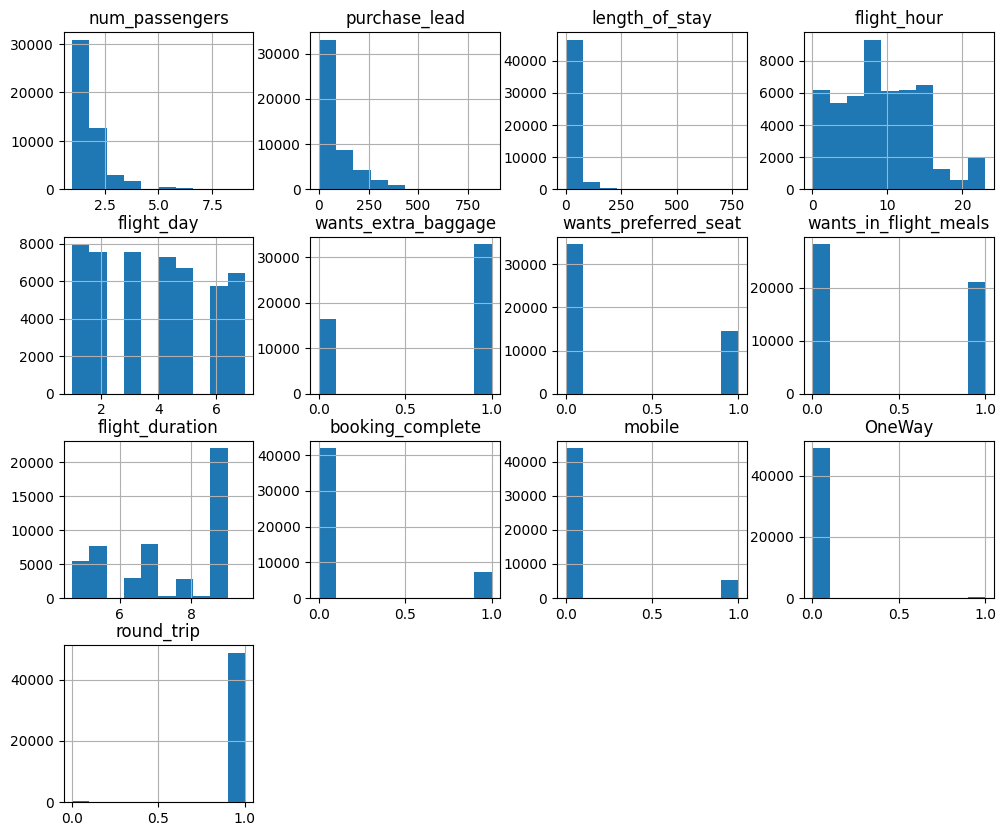

In [84]:
df.hist(figsize=(12, 10))

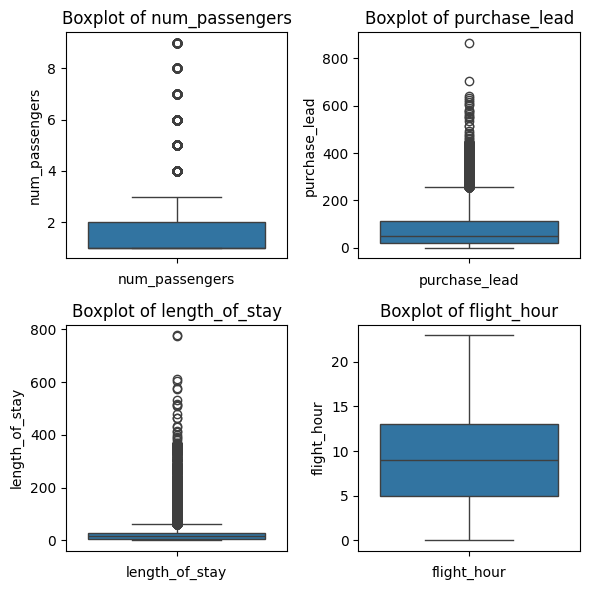

In [110]:
right_skewed_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour']

plt.figure(figsize=(6, 6))

# Create a boxplot for each column
for i, col in enumerate(right_skewed_cols):
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns, index i+1
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [122]:
right_skewed_cols = ['purchase_lead', 'length_of_stay']

df[right_skewed_cols] = df[right_skewed_cols].apply(lambda x: np.log(x+1))

array([[<Axes: title={'center': 'num_passengers'}>,
        <Axes: title={'center': 'purchase_lead'}>,
        <Axes: title={'center': 'length_of_stay'}>,
        <Axes: title={'center': 'flight_hour'}>],
       [<Axes: title={'center': 'flight_day'}>,
        <Axes: title={'center': 'wants_extra_baggage'}>,
        <Axes: title={'center': 'wants_preferred_seat'}>,
        <Axes: title={'center': 'wants_in_flight_meals'}>],
       [<Axes: title={'center': 'flight_duration'}>,
        <Axes: title={'center': 'booking_complete'}>,
        <Axes: title={'center': 'mobile'}>,
        <Axes: title={'center': 'OneWay'}>],
       [<Axes: title={'center': 'round_trip'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

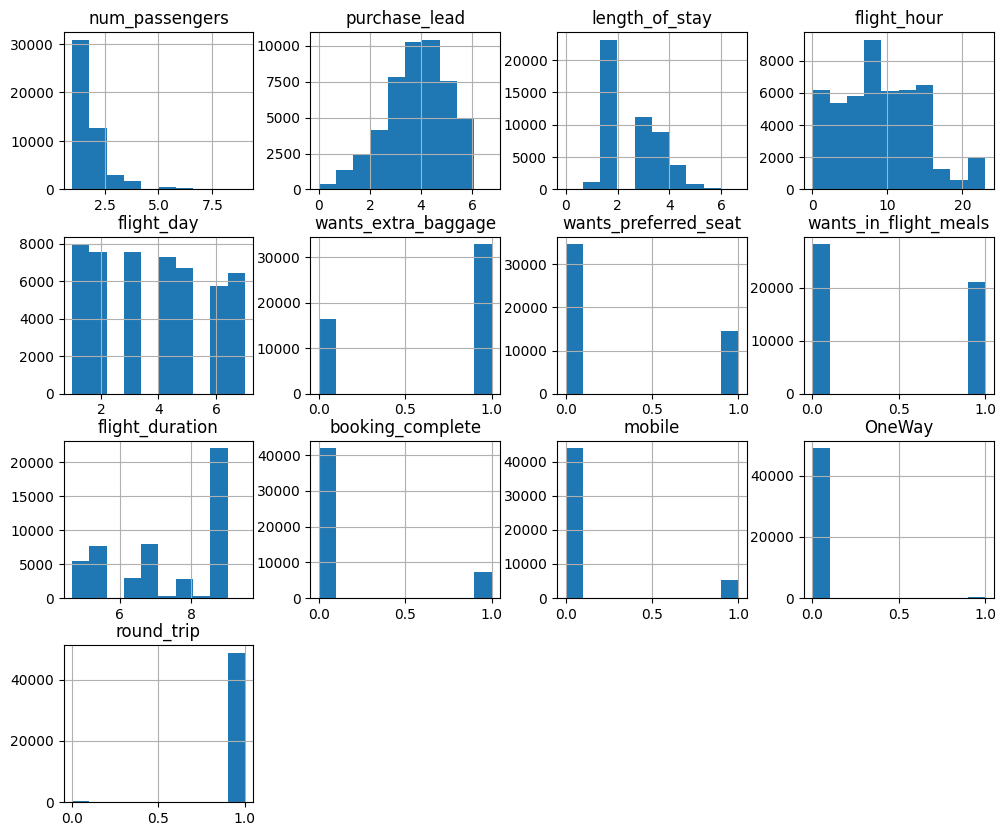

In [123]:
df.hist(figsize=(12, 10))

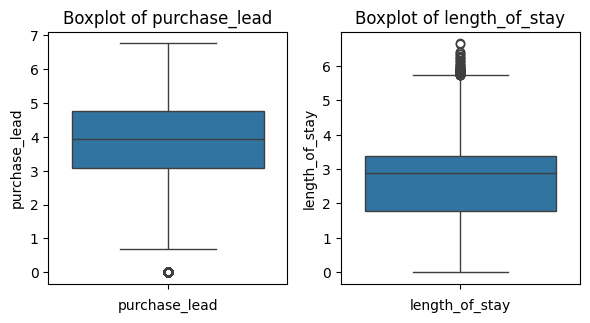

In [124]:
plt.figure(figsize=(6, 6))

# Create a boxplot for each column
for i, col in enumerate(right_skewed_cols):
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns, index i+1
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [125]:
scaler = StandardScaler()

X = df.drop(columns='booking_complete')
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Developmemnt

In [149]:
def model_result(model, x, y):
    model.fit(x, y)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(cm)
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 3)}')
    print(f'Precision: {round(precision_score(y_test, y_pred), 3)}')
    print(f'Recall: {round(recall_score(y_test, y_pred), 3)}')
    print(f'F1_score: {round(accuracy_score(y_test, y_pred), 3)}')

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



def cross_validation(classifier, X, y):
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[8194  184]
 [1397   82]]
Accuracy: 0.84
Precision: 0.308
Recall: 0.055
F1_score: 0.84


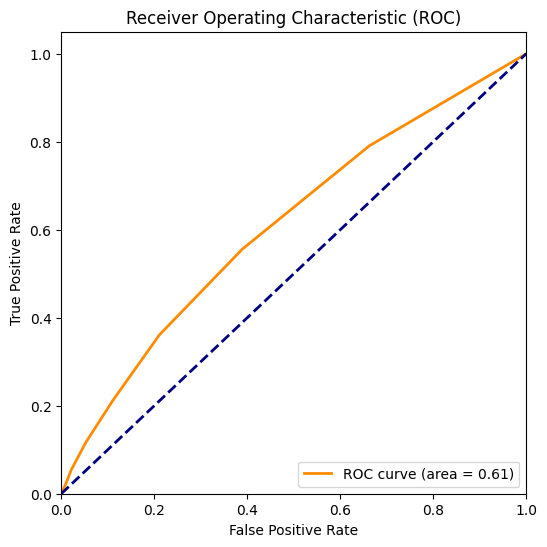

In [140]:
# Random Forest Classifier

rfc_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
model_result(rfc_classifier, X_train, y_train)

[[8378    0]
 [1479    0]]
Accuracy: 0.85
Precision: 0.0
Recall: 0.0
F1_score: 0.85


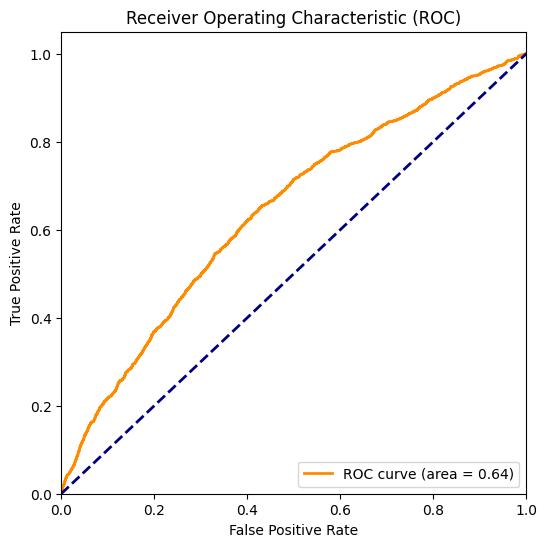

In [133]:
# Logistic Regression

LR = LogisticRegression(random_state = 0)
model_result(LR, X_train, y_train)


[[8083  295]
 [1375  104]]
Accuracy: 0.831
Precision: 0.261
Recall: 0.07
F1_score: 0.831


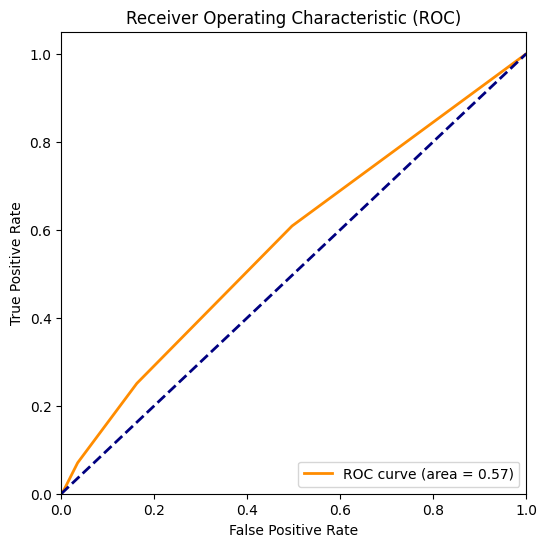

In [134]:
# K-Nearest Neighbours Classifier

KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
model_result(KNN, X_train, y_train)


[[8291   87]
 [1426   53]]
Accuracy: 0.847
Precision: 0.379
Recall: 0.036
F1_score: 0.847


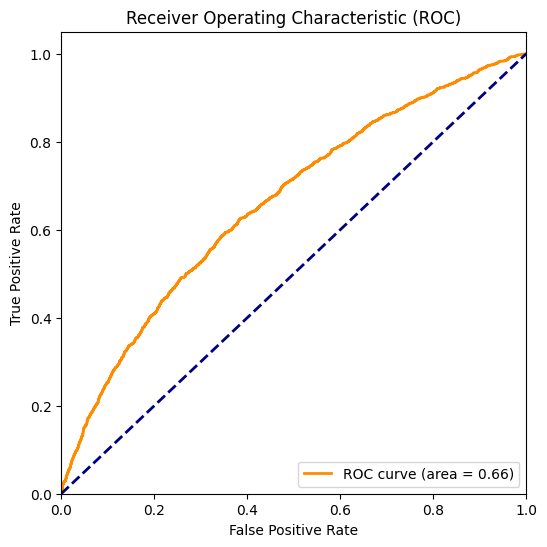

In [135]:
# XGBoost

XGB = XGBClassifier()
model_result(XGB, X_train, y_train)

In [143]:

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


[[7627  687]
 [1452 6990]]
Accuracy: 0.872
Precision: 0.911
Recall: 0.828
F1_score: 0.872


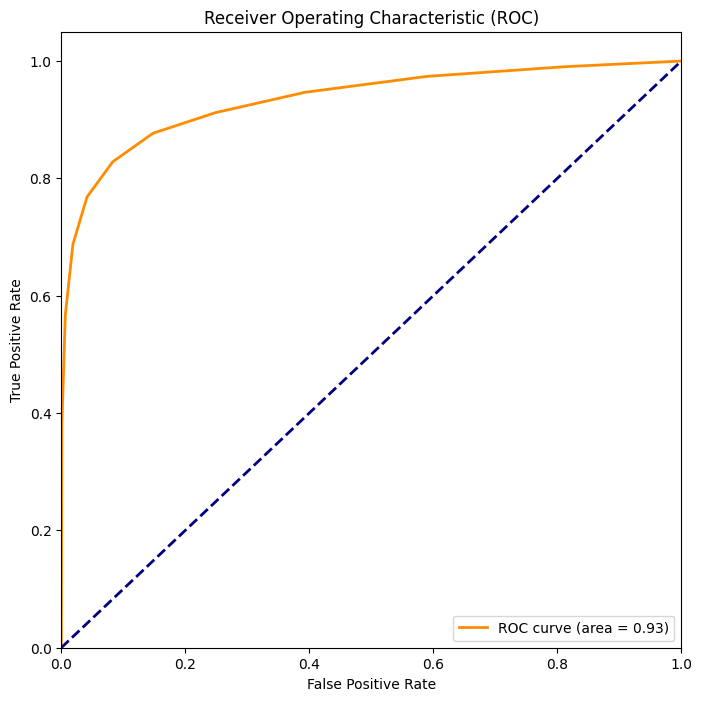

In [146]:
model_result(rfc_classifier, X_train, y_train)

### Then here you attach your model deployment

which is the serialization- creating a pickle file

and deserialization - dumping the pickle file